In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import time

import pickle

## USING PREVIOUS DATA

We want to be able to save thing 

IF PICKLED = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

Change directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /mnt/c/users/rjmay/code/research_ms/plots
Updated Directory: /mnt/c/users/rjmay/code/research_ms


### Simulation stage

In [4]:
from modules.multi_bounds_v3 import bounds_class
from modules.tight_knn_func import knn_num_calc
from modules.data_gen_mv import data_gen_multivariate

In [5]:
sample_sizes = np.logspace(2, 3.3011, 9 , endpoint = True, dtype = int)

sample_sizes

array([ 100,  145,  211,  307,  447,  650,  945, 1375, 2000])

In [6]:
dim = 3

In [7]:
mean_sep = 2.56
# Set the mean and covariance matrix for each Gaussian distribution

mean1 = np.zeros(dim)
covariance1 = np.identity(dim)

mean2 = np.zeros(dim)
mean2[0] = mean_sep
# mean2 = [math.sqrt(1/2), math.sqrt(1/2), 0]

# covariance2 = np.ones((3,3))
covariance2= np.identity(dim)


In [8]:
bound_types =  ["dp", "Bhattacharyya", "Bhatt_knn",  "influence", "enDive"]


##### Run the simulation

In [9]:

bound_obj_lst = []
bound_obj_lst2 = [] 

MC_num = 400

if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:
    
    mean_sep = 2.56
    func0 = np.random.multivariate_normal
    func1 = np.random.multivariate_normal

    dim =3
    mean1 = np.zeros(dim)
    covariance1 = np.identity(dim)

    mean2 = np.zeros(dim)
    mean2[0] = mean_sep
    
    params0 = {'mean': mean1, 'cov': covariance1}
    params1  = {'mean': mean2, 'cov': covariance2}
    
    generator1  = data_gen_multivariate(func0, func1,  params0, params1 )
    
    dim =8

    mean1 = np.zeros(dim)
    covariance1 = np.identity(dim)

    mean2 = np.zeros(dim)
    mean2[0] = mean_sep
    covariance2 = np.identity(dim)

    params0 = {'mean': mean1, 'cov': covariance1}
    params1  = {'mean': mean2, 'cov': covariance2}
    
    generator2  = data_gen_multivariate(func0, func1,  params0, params1 )

    for i in sample_sizes:

        start = time.time()
        sample_size =i 
        
        k = knn_num_calc(i, len(mean1))
        
        if  i < 750:
            threads =2
        else:
            threads = 4

        bounds = bounds_class(generator1, sample_size = sample_size, threads =threads, bound_types= bound_types,   MC_num = MC_num, k_nn  =k )
        
        bound_obj_lst.append(bounds)
        
        
        bounds = bounds_class(generator2, sample_size = sample_size, threads =threads, bound_types= bound_types,   MC_num = MC_num, k_nn  =k )
        
        bound_obj_lst2.append(bounds)
        
        
                
        end = time.time()

        
        
        print("done with ", i, " in ",  end -start )


USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [27]:
file_path = 'sim_data/inc_n_3d.pkl'


if PICKLED  == False:
    objects_to_save = bound_obj_lst, bound_obj_lst2

    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Loaded object successfully


In [28]:
MC_num = len(bound_obj_lst[0])

# dir(bound_obj_lst[0])

In [29]:
bound_obj_lst = bound_obj_lst2

## Using simulated data 

In [30]:
dp_l = []
dp_u = []

Bha_u =[]
Bha_l =[]

Bha_knn_u = []
Bha_knn_l = []

inf_l = []
inf_u = []

enDive_l = []
enDive_u = []


for obj in bound_obj_lst:
    a,b = obj.get_bounds_dp()
    dp_l.append(a)
    dp_u.append(b)
    
    a,b = obj.get_bounds_Bha()
    Bha_l.append(a)
    Bha_u.append(b)

    
#     a, b = obj.get_bounds_tight()
#     tight_l.append(a)
#     tight_u.append(b)
    
    a, b= obj.get_bounds_Bha_knn()
    Bha_knn_l.append(a)
    Bha_knn_u.append(b)
    
    a,b = obj.get_inf_bounds()
    inf_l.append(a)
    inf_u.append(b)
    
    a,b = obj.get_Bounds_enDive()
    enDive_l.append(a)
    enDive_u.append(b)
    
    

### Calculate BER and MSE Function

In [31]:
dx = 0.001
x = np.arange(-5, 8 + dx, dx)

f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
f1 = np.exp(-0.5 * (x - mean_sep)**2) / np.sqrt(2 * np.pi)

fmin = np.minimum(f0, f1)

BER = 0.5 * np.sum(fmin * dx)

print("BER 2d:", BER)

BER 2d: 0.10027258671145768


In [32]:
BER_lst = np.ones(MC_num) * BER


def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

### Theoretical values

In [33]:
from modules.Bhattacharyya_func import Bhattacharyya_bounds as Bhattacharyya_bounds_calc

mean1 = np.array(mean1)
mean2 = np.array(mean2)

theory_bha = Bhattacharyya_bounds_calc([mean1, covariance1], [mean2, covariance2])



MATLAB = [.0792, 0.1459]

In [34]:
theory_bha

(0.05119343219642164, 0.22039207040266226)

In [35]:
cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(MC_num) * (theory_bha[0])
bha_theoretical_u= np.ones(MC_num) * (theory_bha[1])


dp_theoretical_l= np.ones(MC_num) * MATLAB[0]
dp_theoretical_u= np.ones(MC_num) * MATLAB[1]


In [36]:
lower_mse_DP = []
upper_mse_DP =[]

lower_mse_Bha = []
upper_mse_Bha =[]


lower_mse_Bha_knn = []
upper_mse_Bha_knn =[]

lower_mse_inf = []
upper_mse_inf = []

lower_mse_enDive = []
upper_mse_enDive = []

# lower_MSE_tight =[]
# upper_MSE_tight= []


for i in range(len(bound_obj_lst)):
    l_mse = mse(dp_theoretical_l, dp_l[i]) 
    lower_mse_DP.append(l_mse)
    
    u_mse = mse(dp_theoretical_u, dp_u[i]) 
    upper_mse_DP.append(u_mse)       
    
    l_mse = mse(dp_theoretical_l, enDive_l[i]) 
    lower_mse_enDive.append(l_mse)
    
    u_mse = mse(dp_theoretical_u, enDive_u[i]) 
    upper_mse_enDive.append(u_mse)

    
    l_mse = mse(bha_theoretical_l, Bha_l[i]) 
    lower_mse_Bha.append(l_mse)
    
    u_mse = mse(bha_theoretical_u, Bha_u[i])
    upper_mse_Bha.append(u_mse) 
    
    l_mse = mse(bha_theoretical_l, Bha_knn_l[i]) 
    lower_mse_Bha_knn.append(l_mse)
    
    u_mse = mse(bha_theoretical_u, Bha_knn_u[i])
    upper_mse_Bha_knn.append(u_mse) 
    
    l_mse = mse(bha_theoretical_l, inf_l[i]) 
    lower_mse_inf.append(l_mse)
    
    u_mse = mse(bha_theoretical_u, inf_u[i])
    upper_mse_inf.append(u_mse) 
    
#     l_mse =mse(BER_lst, tight_l[i])
#     lower_MSE_tight.append(l_mse)
    
#     u_mse =mse(BER_lst, tight_u[i])
#     lower_MSE_tight.append(u_mse)

### Plotting

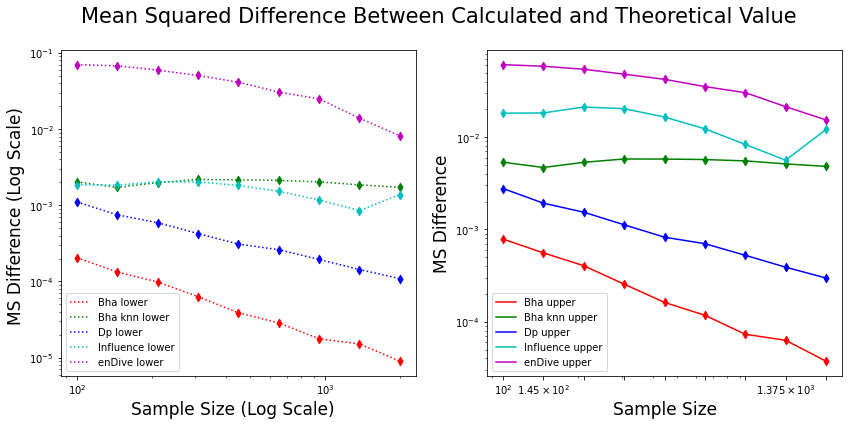

In [37]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
st = fig.suptitle("Mean Squared Difference Between Calculated and Theoretical Value", fontsize=fs+4)
ax = axes[0]


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_Bha,'r:', label='Bha lower')
ax.scatter(sample_sizes, lower_mse_Bha, color = 'red', marker = 'd')

ax.plot(sample_sizes, lower_mse_Bha_knn, color = 'g',linestyle=":",  label = "Bha knn lower")
ax.scatter(sample_sizes, lower_mse_Bha_knn, color = 'g', marker = 'd')


ax.plot(sample_sizes, lower_mse_DP,  'b:', label='Dp lower')
ax.scatter(sample_sizes, lower_mse_DP,  color='b', marker='d')

ax.plot(sample_sizes, lower_mse_inf,  'c:', label='Influence lower')
ax.scatter(sample_sizes, lower_mse_inf,  color='c', marker='d')

ax.plot(sample_sizes, lower_mse_enDive,  'm:', label='enDive lower')
ax.scatter(sample_sizes, lower_mse_enDive,  color='m', marker='d')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MS Difference (Log Scale) ", fontsize=fs)
# ax.set_title("MSE Between  and Theoretical Value", fontsize = fs +4)



ax.legend()

ax = axes[1]

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_Bha,'r-', label='Bha upper')
ax.scatter(sample_sizes, upper_mse_Bha, color = 'red', marker = 'd')


ax.plot(sample_sizes, upper_mse_Bha_knn, color = 'g',  label = "Bha knn upper")
ax.scatter(sample_sizes, upper_mse_Bha_knn, color = 'g', marker = 'd')


ax.plot(sample_sizes, upper_mse_DP,  'b-', label='Dp upper')
ax.scatter(sample_sizes, upper_mse_DP,  color='b', marker='d')

ax.plot(sample_sizes, upper_mse_inf,  'c-', label='Influence upper')
ax.scatter(sample_sizes, upper_mse_inf,  color='c', marker='d')

ax.plot(sample_sizes, upper_mse_enDive,  'm-', label='enDive upper')
ax.scatter(sample_sizes, upper_mse_enDive,  color='m', marker='d')

ax.set_xlabel("Sample Size", fontsize = fs)
ax.set_ylabel("MS Difference", fontsize=fs)
# ax.set_title("Mean Squared Difference Between and Theoretical Value", fontsize = fs +4)

ax.legend()

# plt.savefig("log_test.png",facecolor=(1,1,1,1))
ax.set_xticks(sample_sizes)
plt.show()


Bhattacharyya, Bha Knn, influence same theoretically

Dp, enDive

In [38]:
# validity_dp_l = np.zeros(len(sample_sizes))
# validity_dp_u = np.zeros(len(sample_sizes))

# validity_Bha_l = np.zeros(len(sample_sizes))
# validity_Bha_u =  np.zeros(len(sample_sizes))

# validity_tight_l = np.zeros(len(sample_sizes))
# validity_tight_u =  np.zeros(len(sample_sizes))

# for i in range(len(sample_sizes)):
# #     Bha_l, Bha_u = Bha_lst[i].get_bounds()
# #     dp_l, dp_u = dp_lst[i].get_bounds()
#     for j in range(MC_num):
#         if Bha_l[i][j] < BER:
#             validity_Bha_l[i] += 1
#         if Bha_u[i][j] > BER:
#             validity_Bha_u[i] += 1
    
#         if dp_l[i][j] < BER:
#             validity_dp_l[i] += 1
#         if dp_u[i][j] > BER:
#             validity_dp_u[i] += 1
#         if tight_l[i][j] < BER:
#             validity_tight_l[i] += 1
#         if tight_u[i][j]> BER:
#             validity_tight_u[i] += 1

# print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

In [39]:
BER

0.10027258671145768

In [40]:
lst = [obj.validity(BER) for obj in bound_obj_lst ]

df_valid = pd.DataFrame(lst, index = sample_sizes)

df_valid


,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper,enDive_lower,enDive_upper
100,0.4575,0.9950,0.995,1.0,0.6675,1.0,NaN,NaN,NaN,1.0,0.4050,0.4850,0.5450
145,0.5200,0.9925,1.000,1.0,0.7850,1.0,NaN,NaN,NaN,1.0,0.1975,0.5000,0.5475
211,0.5650,1.0000,1.000,1.0,0.6950,1.0,NaN,NaN,NaN,1.0,0.2575,0.4975,0.5525
307,0.6400,1.0000,1.000,1.0,0.6650,1.0,NaN,NaN,NaN,1.0,0.0175,0.5150,0.5675
447,0.7475,1.0000,1.000,1.0,0.6700,1.0,NaN,NaN,NaN,1.0,0.0000,0.4950,0.6100
650,0.8050,1.0000,1.000,1.0,0.7200,1.0,NaN,NaN,NaN,1.0,1.0000,0.4875,0.6075
945,0.9025,1.0000,1.000,1.0,0.8175,1.0,NaN,NaN,NaN,1.0,0.9975,0.4950,0.6500
1375,0.9750,1.0000,1.000,1.0,0.9125,1.0,NaN,NaN,NaN,1.0,1.0000,0.5275,0.6675
2000,0.9975,1.0000,1.000,1.0,0.9850,1.0,NaN,NaN,NaN,1.0,0.6300,0.5100,0.7300


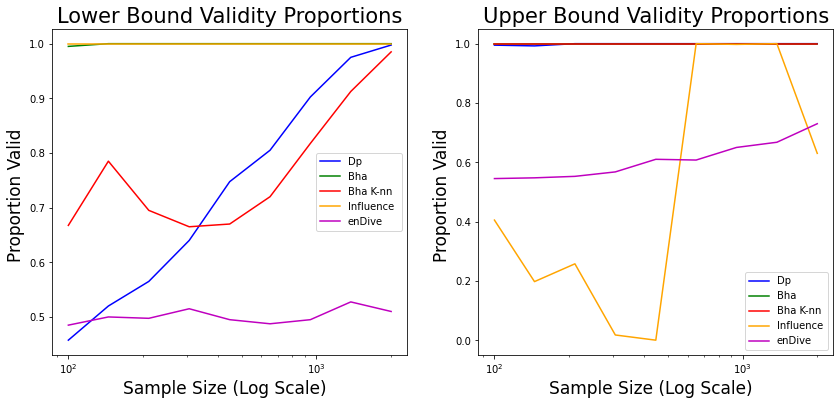

In [41]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df_valid["Dp_lower"], 'b',  label='Dp  ')
# ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='Upper Dp Validity ')

ax.plot(df_valid["Bha_lower"],'g', label='Bha  ')
# ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')

ax.plot(df_valid["Bha_knn_lower"],'r', label='Bha K-nn  ')
# ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')

ax.plot(df_valid["inf_lower"],'orange', label='Influence')

ax.plot(df_valid["enDive_lower"],'m', label='enDive')


# ax.plot(df_valid["tight_lower"],'orange', label='Tight  ')


# ax.plot(sample_sizes, validity_tight_u/ MC_num,  label='Upper Tight Validity ')
# ax.set_xticks(sample_sizes)

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]


ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df_valid["Dp_upper"], 'b',  label='Dp  ')

ax.plot(df_valid["Bha_upper"],'g', label='Bha  ')

ax.plot(df_valid["Bha_knn_upper"],'r', label='Bha K-nn ')

# ax.plot(df_valid["Maha_upper"],'black', label='Maha ')
ax.plot(df_valid["inf_upper"],'orange', label='Influence')

ax.plot(df_valid["enDive_upper"],'m', label='enDive')


# ax.plot(df_valid["tight_upper"],'orange', label='Tight  ')
# ax.set_xticks(sample_sizes)
ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion Valid ", fontsize=fs)
ax.set_title("Upper Bound Validity Proportions" , fontsize = fs +4)
ax.legend()

# plt.savefig("proportions_n.png",facecolor=(1,1,1,1))
plt.show()